In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [2]:
from collections import defaultdict
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier

from gensim.models import Word2Vec, Doc2Vec

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Bidirectional, 
    LSTM, GRU, Embedding, SpatialDropout1D, GlobalMaxPooling1D, 
    GlobalAveragePooling1D, Conv1D, TimeDistributed, MaxPool1D, Flatten
)
from tensorflow.compat.v1.keras.layers import CuDNNLSTM 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

Using TensorFlow backend.


Num GPUs Available:  1


In [3]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1



In [24]:
classes = 2
max_words = 20000
maxlen = 32
batch_size = 128
epochs = 30

In [25]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [26]:
print(random.choice(textos))
print(len(textos))
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['nao sei febre mas ando constantemente com sono chega ser insuportavel' 1]
2197


In [27]:
# word_counts = defaultdict(int)
# for phrases in textos[:, 0]:
#     for word in phrases.split():
#         word_counts[word] += 1
# v_count = len(word_counts.keys())
# words_list = list(word_counts.keys())
# word_index = dict((word, i) for i, word in enumerate(words_list))

# X = []
# for phrases in textos[:, 0]:
#     xp = []
#     for word in phrases.split():
#         xp.append(word_index[word])
#     X.append(xp)
# y = textos[:, 1].astype(np.int).ravel()
# y = to_categorical(y, classes)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# tokenizer = Tokenizer(num_words=max_words)
# X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
# X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')

In [28]:
X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tokenizer = Tokenizer(num_words=max_words, lower=True, char_level=False)
tokenizer.fit_on_texts(X)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

clf = LogisticRegression(
    random_state=0
).fit(X_train, y_train)
pred = clf.predict(X_test)

round(np.mean(y_test == pred) * 100)

65.0

In [29]:
X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()
y = to_categorical(y, classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tokenizer = Tokenizer(num_words=max_words, lower=True, char_level=False)
tokenizer.fit_on_texts(X)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [30]:
word_index = tokenizer.word_index

embeddings_index = {}
w2v = Word2Vec.load(f"{os.getcwd()}/../ai/models/w2v.model")

for phrase in X:
    for word in phrase.split():
        try:
            embeddings_index[word] = w2v.wv[word]
        except:
            embeddings_index[word] = np.zeros(300, )
print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 6112 word vectors.


In [31]:
X_train[0], X_test[0]

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 2146,    2,   92,  871,   40, 1624],
       dtype=int32),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    7,  177,   83,  236, 2468,  388,
           1,    4, 5214,  328,  219, 2131, 1547,  219,  998,  766],
       dtype=int32))

In [32]:
model = Sequential()
# model.add(Dense(1024, input_shape=(max_words,)))
model.add(Embedding(
    len(word_index) + 1, 
    output_dim=300, 
    weights=[embedding_matrix],
    trainable=False,
    input_length=maxlen))
model.add(Conv1D(128, 2, activation='relu'))
model.add(MaxPool1D(2))
model.add(Conv1D(128, 2, activation='relu'))
model.add(MaxPool1D(2))
model.add(Conv1D(128, 2, activation='relu'))
model.add(MaxPool1D(2))
# model.add(Conv1D(32, 3, activation='relu'))
# model.add(Conv1D(64, 3, activation='relu'))
# model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(GRU(16)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.metrics_names)

[]


In [33]:
# # For Conv & LSTM
# print(X_train.shape)
# print(X_test.shape)
# # X_train = X_train.reshape(1430, 15000, -1)
# # X_test = X_test.reshape(614, 15000, -1)
# X_train = X_train.astype(np.float32)
# X_test = X_test.astype(np.float32)

In [34]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=0.1)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', round(score[1] * 100))

4/4 [==============================] - 0s 3ms/step - loss: 1.3427 - accuracy: 0.7159
Test loss: 1.342716097831726
Test accuracy: 72


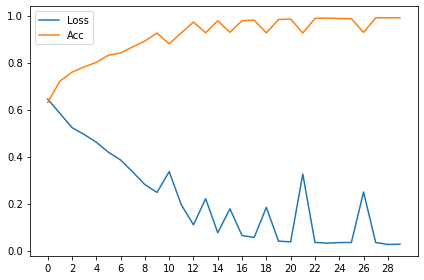

In [35]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["accuracy"], label="Acc")
plt.xticks(range(0, epochs, 2))
plt.legend()
plt.tight_layout()
plt.show()

### Do2Vec

In [36]:
d2v = Doc2Vec.load(f"{os.getcwd()}/../ai/models/d2v.model")

n_textos = []
for texto in textos:
    doc_vec = d2v.infer_vector(texto[0].split(), epochs=500)
    n_textos.append(doc_vec)
n_textos = np.asarray(n_textos)

In [37]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()
y = to_categorical(y, classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [38]:
# # For Conv & LSTM
print(X_train.shape)
print(X_test.shape)
X_train = X_train.reshape(1757, 300, -1)
X_test = X_test.reshape(440, 300, -1)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

(1757, 300)
(440, 300)


In [39]:
model = Sequential()
# model.add(Dense(1024, input_shape=(300,)))
model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPool1D())
# model.add(Conv1D(32, 3, activation='relu'))
# model.add(Conv1D(64, 3, activation='relu'))
model.add(SpatialDropout1D(0.1))
# model.add(Bidirectional(GRU(4)))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.metrics_names)

[]


In [40]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=0.2)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', round(score[1] * 100))

4/4 [==============================] - 0s 6ms/step - loss: 0.7825 - accuracy: 0.6682
Test loss: 0.7824962735176086
Test accuracy: 67


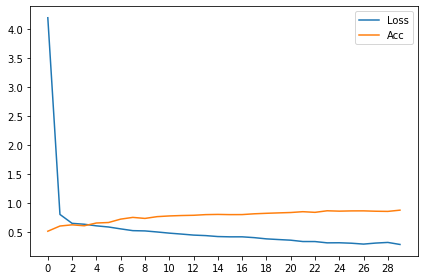

In [41]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["accuracy"], label="Acc")
plt.xticks(range(0, epochs, 2))
plt.legend()
plt.tight_layout()
plt.show()